Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. 

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook,nlp]
```

In [2]:
!pip install flaml[notebook,nlp];
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# !pip install flaml[catboost]

## 2. Sequence Classification Example
### Load data and preprocess

The Microsoft Research Parallel Corpus (MRPC) is a dataset for paraphrase detection. An example pair of sentences is:

* sentence 1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
* sentence 2: Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

First, let's load this dataset in to pandas dataframes: 

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "mrpc", split="train").to_pandas()
dev_dataset = load_dataset("glue", "mrpc", split="validation").to_pandas()
test_dataset = load_dataset("glue", "mrpc", split="test").to_pandas()

In [ ]:
custom_sent_keys = ["sentence1", "sentence2"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [12]:
automl_settings = {
    "time_budget": 100,                                 # setting the time budget
    "task": "seq-classification",                       # specifying your task is seq-classification 
    "custom_hpo_args": {"output_dir": "data/output/", "fp16": False},  # specifying your output directory
    "gpu_per_trial": 0,                                 # set to 0 if no GPU is available
}

In [ ]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

### Best model and metric

In [5]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 1071, 'num_leaves': 25, 'min_child_samples': 36, 'learning_rate': 0.10320258241974468, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.08547376339713011, 'FLAML_sample_size': 364083}
Best accuracy on validation data: 0.6696
Training duration of best run: 9.274 s


In [6]:
automl.model.estimator

LGBMClassifier(learning_rate=0.10320258241974468, max_bin=1023,
               min_child_samples=36, n_estimators=1071, num_leaves=25,
               reg_alpha=0.0009765625, reg_lambda=0.08547376339713011,
               verbose=-1)

In [7]:
'''pickle and save the automl object'''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [8]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['1' '0' '1' ... '1' '0' '0']
True labels 118331    0
328182    0
335454    0
520591    1
344651    0
         ..
367080    0
203510    1
254894    0
296512    1
362444    0
Name: Delay, Length: 134846, dtype: category
Categories (2, object): ['0' < '1']


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 14, 'min_child_samples': 15, 'learning_rate': 0.22841390623808822, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.0014700173967242716, 'reg_lambda': 7.624911621832711, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 14, 'min_child_samples': 15,

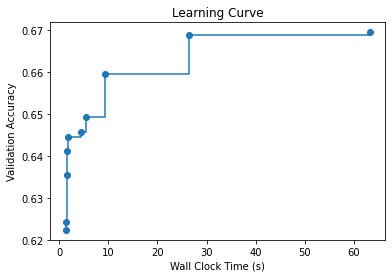

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()